In [1]:
# imports
%matplotlib inline
import pandas as pd
from lightgbm import LGBMRegressor
import xgboost as xgb
import optuna.integration.lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("notebook")

/Users/ironmonkeyapps/miniconda3/envs/jpx/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ironmonkeyapps/miniconda3/envs/jpx/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load stock price train and test dataset
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
supplemental_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
testprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")
teststockprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv")

prices = prices.append(sprices,ignore_index=True)
prices = prices.append(supplemental_prices,ignore_index=True)
prices = prices.append(supplemental_sprices,ignore_index=True)
prices = prices.drop(['RowId'],axis=1)
prices = prices.dropna()
prices['ExpectedDividend'] = prices['ExpectedDividend'].fillna(0)
prices['SupervisionFlag'] = prices['SupervisionFlag'].map({True: 1, False: 0})

# df_test = df_test.drop(['RowId','ExpectedDividend'],axis=1)
# df_test = df_test.dropna()
# df_test['ExpectedDividend'] = df_test['ExpectedDividend'].fillna(0)
# df_test['SupervisionFlag'] = df_test['SupervisionFlag'].map({True: 1, False: 0})

FileNotFoundError: [Errno 2] No such file or directory: '../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv'

In [4]:
df_train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1760342,20201005_7246,2020-10-05,7246,292.0,298.0,291.0,297.0,245500,1.0,NaN,False,-0.003257
1760343,20201005_7250,2020-10-05,7250,987.0,1018.0,987.0,996.0,170600,1.0,NaN,False,0.006863
1760344,20201005_7254,2020-10-05,7254,176.0,176.0,176.0,176.0,200,1.0,NaN,False,-0.016667
1760352,20201005_7278,2020-10-05,7278,1361.0,1390.0,1359.0,1388.0,146700,1.0,NaN,False,-0.001441
1760345,20201005_7259,2020-10-05,7259,3425.0,3525.0,3420.0,3475.0,1112300,1.0,NaN,False,0.007246


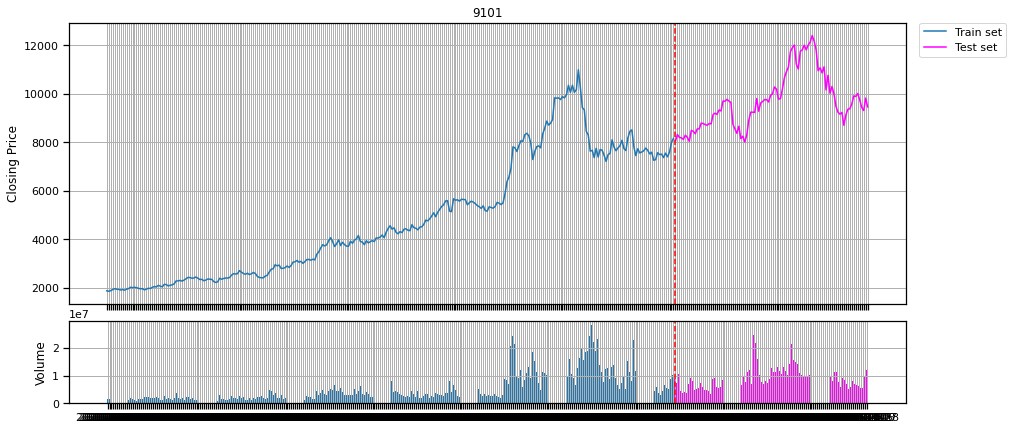

In [5]:
# get singel example stock
Code = 9101
STOCK = df_train[df_train.SecuritiesCode==Code].set_index("Date")
TEST = df_test[df_test.SecuritiesCode==Code].set_index("Date")
# plot test and train timeframes
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(STOCK.index, STOCK.Close, label="Train set")
top.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
bottom.bar(STOCK.index, STOCK.Volume)
bottom.bar(TEST.index, TEST.Volume, color="magenta")
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)

# set the labels
top.axes.xaxis.set_ticklabels([])
top.axvline(TEST.index[0], color='red', linestyle='--')
bottom.axvline(TEST.index[0], color='red', linestyle='--')
top.set_title(Code)
top.grid(True)
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
bottom.grid(True);


In [20]:
def featuring(train):
    dfa=pd.DataFrame()
    for code in train['SecuritiesCode'].unique():
        df=train[train['SecuritiesCode']==code]

        df=df.sort_values(by=['Date'], ascending=True)
        df['RA_20'] = df.Close.rolling(5, min_periods=1).mean()
        df['RA_40'] = df.Close.rolling(10, min_periods=1).mean()
        df['RA_60'] = df.Close.rolling(15, min_periods=1).mean()
        df['RA_80'] = df.Close.rolling(20, min_periods=1).mean()
        df['RA_100'] = df.Close.rolling(30, min_periods=1).mean()
        dfa=pd.concat([dfa, df])
    dfa['year']=pd.to_numeric(dfa['Date'].str[0:4]).astype(float)
    dfa['month']=pd.to_numeric(dfa['Date'].str[5:7]).astype(float)
    dfa['day']=pd.to_numeric(dfa['Date'].str[8:10]).astype(float)
    dfa['delta']=pd.to_numeric(dfa['High']-dfa['Low']).astype(float)
    dfa['change']=pd.to_numeric(dfa['Close']-dfa['Open']).astype(float)
    dfa=dfa[['Date','SecuritiesCode','delta','change','RA_20','RA_40','RA_60','RA_80','RA_100','year','month','day']]
    train=train.merge(dfa,how='left',on=['Date','SecuritiesCode'],suffixes=('', 'b')).set_axis(train.index)
    train=train.drop(['Date'],axis=1)

    return train

In [21]:
y_train = df_train.pop("Target")
y_val = df_test.pop("Target")
X_train = featuring(df_train)
X_val = featuring(df_test)

In [15]:
y_train.head()

1760342   -0.003257
1760343    0.006863
1760344   -0.016667
1760352   -0.001441
1760345    0.007246
Name: Target, dtype: float64

In [22]:
# lgbm model fit
model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=18,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.8,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist' # THE MAGICAL PARAMETER
    )
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1)

/Users/ironmonkeyapps/miniconda3/envs/jpx/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoostError: [17:35:21] /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000132604364 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x00000001326948ee xgboost::gbm::GBTree::ConfigureUpdaters() + 478
  [bt] (2) 3   libxgboost.dylib                    0x0000000132694417 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 1207
  [bt] (3) 4   libxgboost.dylib                    0x00000001326b20ca xgboost::LearnerConfiguration::Configure() + 1546
  [bt] (4) 5   libxgboost.dylib                    0x00000001326080a4 XGBoosterBoostedRounds + 116
  [bt] (5) 6   libffi.8.dylib                      0x0000000108bc3d92 ffi_call_unix64 + 82
  [bt] (6) 7   ???                                 0x00007ffee7f95a90 0x0 + 140732790299280



In [ ]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [9]:
# test loop ala submission
for (df_test, options, financials, trades, secondary_prices, df_pred) in iter_test:
    df_test=df_test.drop(['RowId','ExpectedDividend'],axis=1)
    x_test = featuring(df_test)
    y_pred = model.predict(x_test)
    df_pred['Target'] = y_pred
    df_pred = df_pred.sort_values(by = "Target", ascending = False)
    df_pred['Rank'] = np.arange(len(df_pred.index))
    df_pred = df_pred.sort_values(by = "SecuritiesCode", ascending = True)
    df_pred.drop(["Target"], axis = 1)
    submission = df_pred[["Date", "SecuritiesCode", "Rank"]]    
    env.predict(submission)

(2000, 14)
(2000, 14)
